<img src="../illustrations/VQ-VAE.png" width="500" height="300">

# Setup

To run this notebook on Colab, a few setup steps are required. Follow along step by step:

1. **Clone the `dlfb` library**  
   First, clone the repository that contains the `dlfb` library.

In [2]:
%cd /content
!rm -rf ./dlfb-clone/
!git clone "https://github.com/deep-learning-for-biology/dlfb.git" dlfb-clone --branch main
%cd dlfb-clone

/content
Cloning into 'dlfb-clone'...
remote: Enumerating objects: 121, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 121 (delta 19), reused 111 (delta 13), pack-reused 0 (from 0)
Receiving objects: 100% (121/121), 62.31 KiB | 2.40 MiB/s, done.
Resolving deltas: 100% (19/19), done.
/content/dlfb-clone


2. **Install dependencies**  
   Once the library is cloned, install the required dependencies.

In [2]:
%%bash
curl -LsSf https://astral.sh/uv/install.sh | sh && \
export PATH="/root/.local/bin:${PATH}" && \
uv pip compile ./requirements/{base,dlfb,localization,gpu}.txt \
  --color never \
  --constraint ./requirements/constraints.txt | \
uv pip install -r - --system

no checksums to verify
installing to /usr/local/bin
  uv
  uvx
everything's installed!


downloading uv 0.9.11 x86_64-unknown-linux-gnu
Resolved 98 packages in 1.56s
Using Python 3.12.12 environment at: /usr
Resolved 98 packages in 420ms
Prepared 50 packages in 12.84s
Uninstalled 37 packages in 487ms
Installed 50 packages in 156ms
 - absl-py==1.4.0
 + absl-py==2.3.1
 + adjusttext==1.3.0
 - cachetools==5.5.2
 + cachetools==6.2.2
 - certifi==2025.11.12
 + certifi==2022.12.7
 - charset-normalizer==3.4.4
 + charset-normalizer==2.1.1
 - click==8.3.1
 + click==8.1.8
 + dlfb==0.1.1 (from file:///content/dlfb-clone)
 - filelock==3.20.0
 + filelock==3.19.1
 - flax==0.10.7
 + flax==0.10.4
 - fsspec==2025.3.0
 + fsspec==2025.9.0
 - google-auth==2.38.0
 + google-auth==2.43.0
 - google-cloud-storage==2.19.0
 + google-cloud-storage==3.0.0
 - idna==3.11
 + idna==3.4
 + ipinfo==5.1.1
 - jax==0.7.2
 + jax==0.5.1
 - jax-cuda12-pjrt==0.7.2
 + jax-cuda12-pjrt==0.5.1
 - jax-cuda12-plugin==0.7.2
 + jax-cuda12-plugin==0.5.1
 - jaxlib==0.7.2
 + jaxlib==0.5.1
 - llvmlite==0.43.0
 + llvmlite==0.45.

3. **Providion the datasets**  
   You’ll then need to access and download the necessary datasets for this chapter.

In [3]:
# from google.colab import auth

# auth.authenticate_user()
# # NOTE: exclude models with '--no-models' flag
!dlfb-provision --chapter localization

Files Downloaded: 100% 53/53 [00:00<00:00, 62.88file/s] 
Files Downloaded: 100% 2/2 [00:00<00:00,  9.10file/s]


4. **Load the `dlfb` package**  
   Finally, load the `dlfb` package.  
   - ⚠️ Note: Loading can sometimes be finicky. If you encounter issues, simply **restart the runtime**. All previously downloaded data and installed packages will persist, so you can re-run the load step without repeating everything.

In [4]:
# Toggle JAX_DISABLE_JIT to True for easier debugging
%env JAX_DISABLE_JIT=False

try:
  import dlfb
except ImportError as exc:
  # NOTE: Packages installed in editable mode are not immediately
  #       recognized by Colab (https://stackoverflow.com/a/63312333).
  import site
  site.main()
  import dlfb

from dlfb.utils.display import display

env: JAX_DISABLE_JIT=False


# 6. Learning Spatial Organization Patterns Within Cells


## 6.1. Biology Primer
### 6.1.1. Spatial Organization within the Cell
### 6.1.2. Protein Localization
### 6.1.3. Understanding Protein Localization


## 6.2. Machine Learning Primer
### 6.2.1. Autoencoders
### 6.2.2. Variational Autoencoders
#### 6.2.2.1. Why add randomness?
#### 6.2.2.2. Continuous Latent Space
### 6.2.3. Vector-Quantized Variational Autoencoders (VQ-VAEs)
#### 6.2.3.1. Where Does the Codebook Come From?
#### 6.2.3.2. How Large Should the Codebook Be?
### 6.2.4. Dissecting a VQ-VAE Diagram
### 6.2.5. Training a VQ-VAE


## 6.3. Constructing the Dataset
### 6.3.1. Data Requirements
### 6.3.2. Sourcing the Data
### 6.3.3. Getting a Glimpse of the Dataset


The dataset contains 1,311 fluorescently tagged proteins, each imaged in roughly 18 different fields of view. From each field of view, about 45 individual crops are extracted, each typically containing around three cells. This yields roughly 800 image crops per protein, totaling more than 1,048,800 images in the full dataset. 

Each image includes two channels: 
- The green protein channel, showing the location of the fluorescently tagged protein of interest. This is the only channel used for training in this chapter. 
- A nuclear stain using Hoechst, a blue fluorescent dye that binds strongly to DNA. This highlights the nuclei of the cells and provides spatial context, for example, helping to identify whether a protein is nuclear, cytoplasmic, or membrane bound.

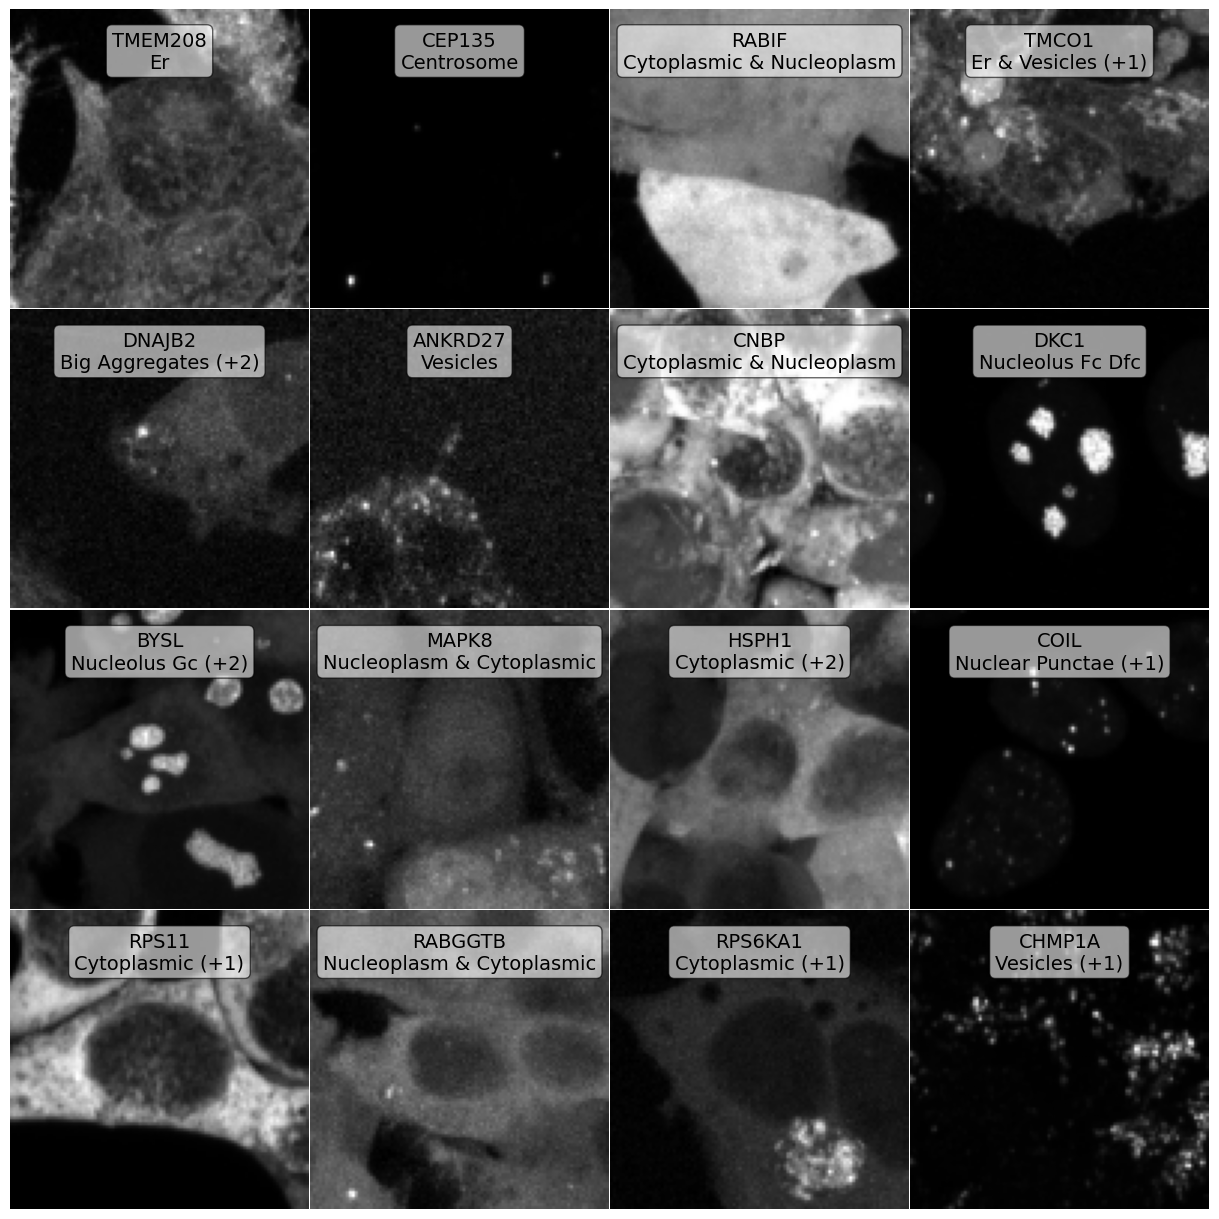

In [5]:
import jax

from dlfb.localization.dataset.utils import get_dataset
from dlfb.utils.context import assets

rng = jax.random.PRNGKey(42)
rng, rng_frames = jax.random.split(rng, 2)

dataset = get_dataset(data_path=assets("localization/datasets"))
n_frames = 16
dataset.plot_random_frames(n=n_frames, rng=rng_frames);

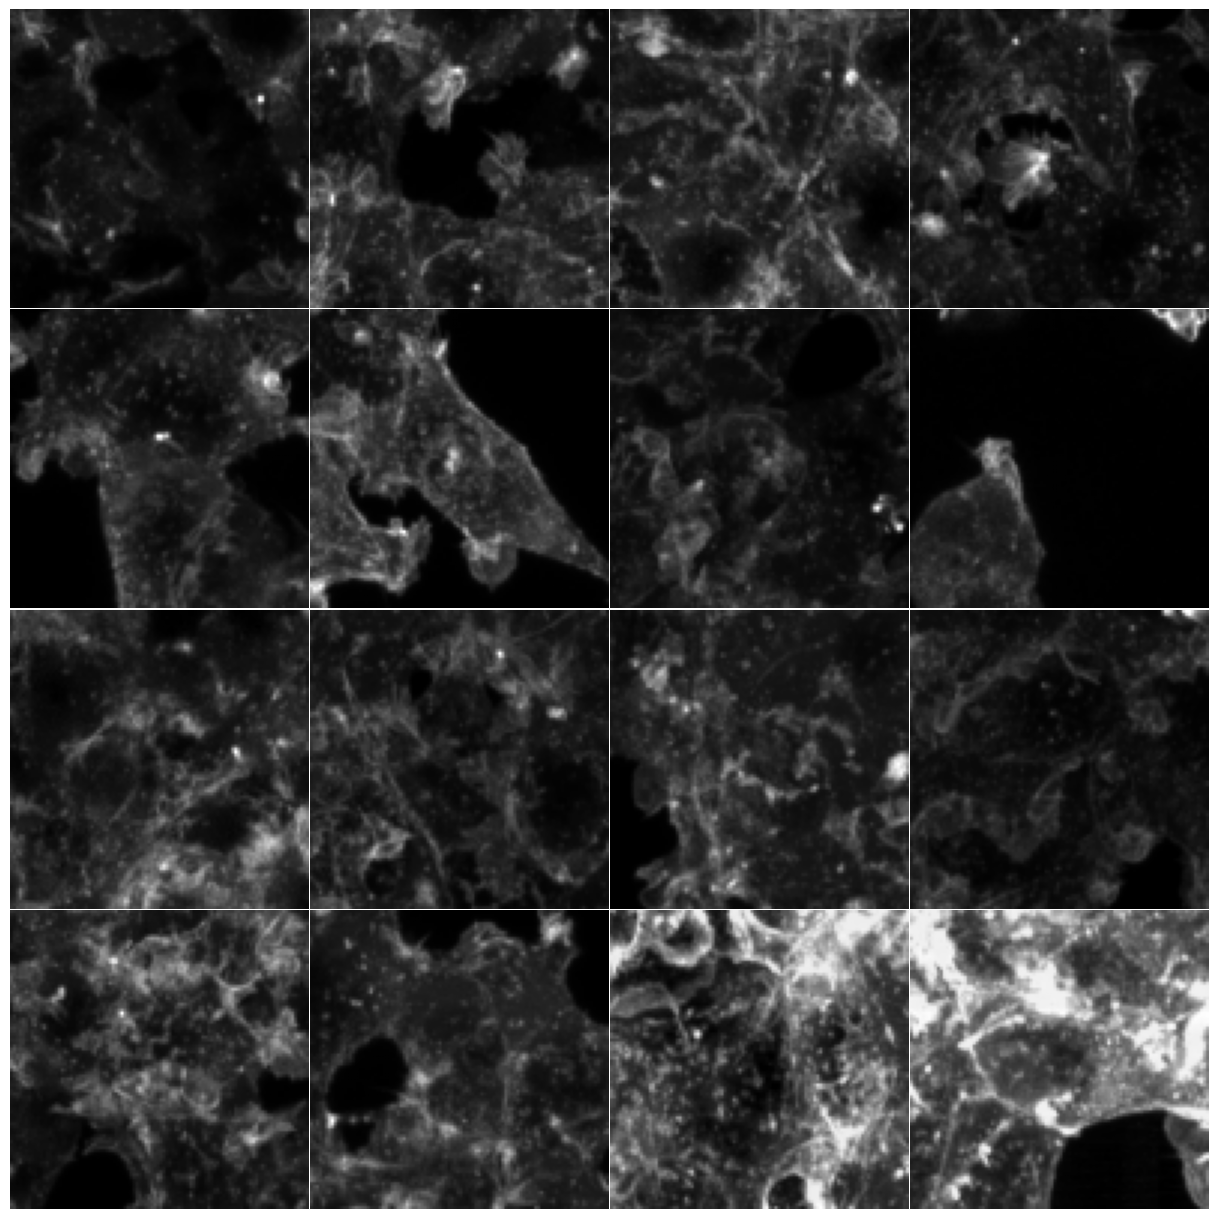

In [6]:
selected_protein = "ACTB"
dataset.plot_random_frames(
  n=n_frames, with_labels=False, rng=rng_frames, gene_symbols=[selected_protein]
);

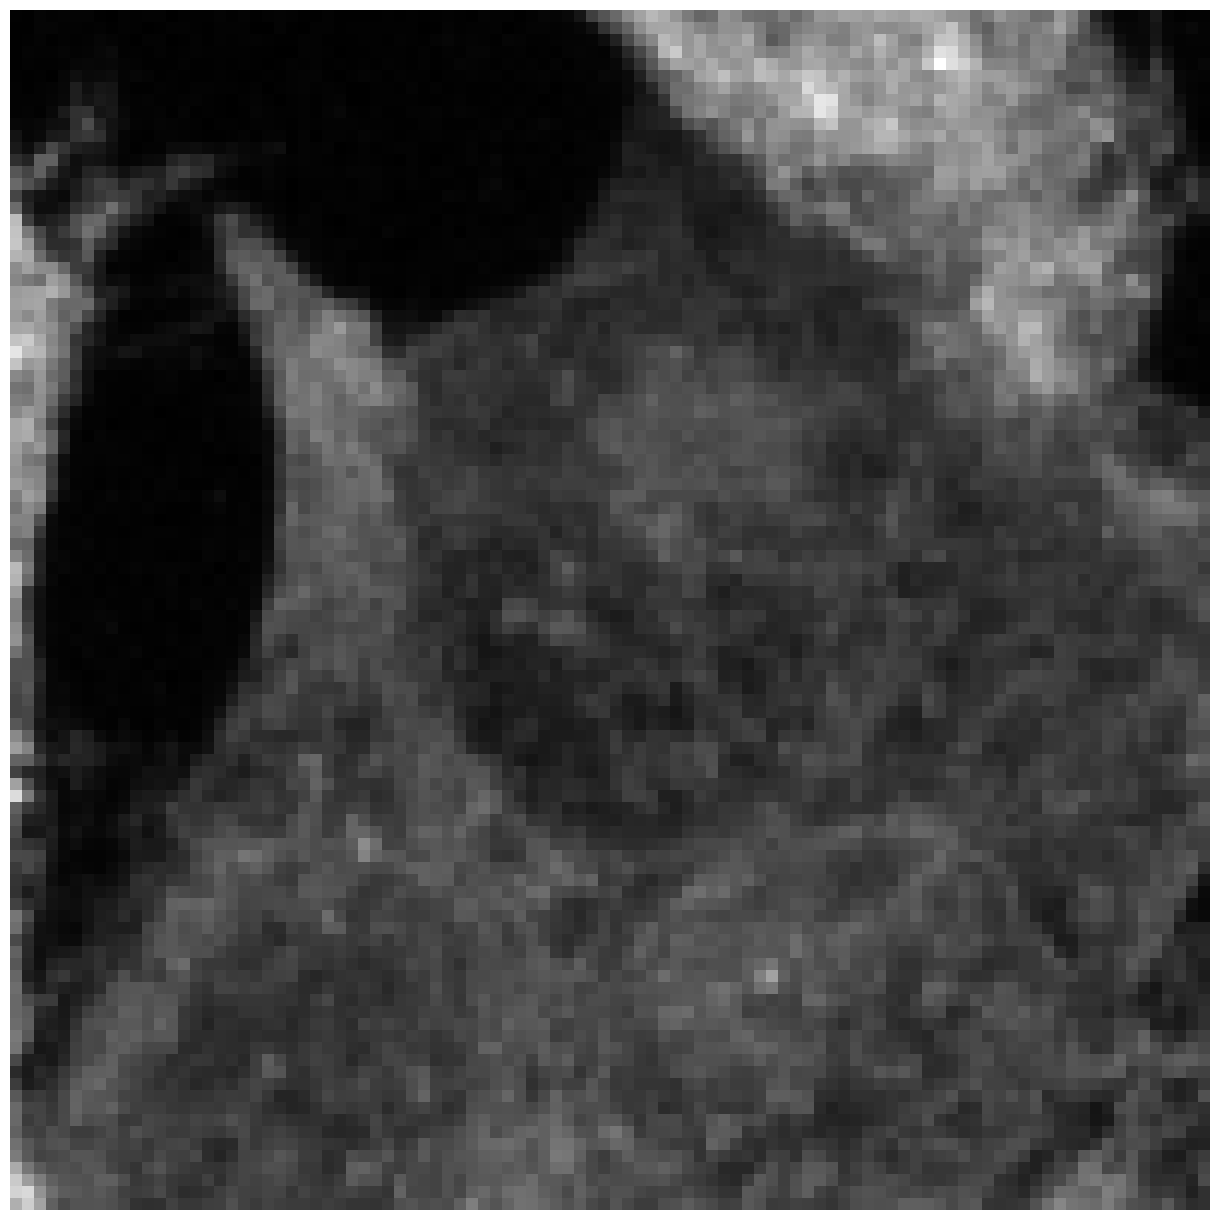

In [7]:
dataset.plot_random_frames(n=1, with_labels=False, rng=rng_frames);

### 6.3.4. Implementing a DatasetBuilder Class


In [8]:
from dlfb.localization.dataset.builder import DatasetBuilder

display([DatasetBuilder])
# exclusive_by flag ensures no data leakage between train/val/test sets
# n_proteins and max_frames adjust dataset size for faster experimentation

class DatasetBuilder:
  """Builds a dataset with splits for learning."""

  def __init__(self, data_path: str, force_recreate: bool = False):
    self.images = ImageLoader(data_path).load(force_recreate=force_recreate)
    self.labels = LabelLoader(data_path).load(force_recreate=force_recreate)

  def build(
    self,
    rng: jax.Array,
    splits: dict[str, float],
    exclusive_by: str = "fov_id",
    n_proteins: int | None = None,
    max_frames: int | None = None,
  ) -> dict[str, Dataset]:
    """Retrieve a dataset of proteins split into learning sets."""
    validate_splits(splits)

    if not n_proteins:
      n_proteins = self.labels.get_n_proteins()

    # Sample frames from chosen proteins.
    rng, rng_proteins = jax.random.split(rng, num=2)
    frames = self.labels.get_frames_of_random_proteins(rng_proteins, n_proteins)

    n_frames = frames.shape[0]
    if max_frames is not None and n_frames > max_frames:
      # Limit number of frames used.
      frames = frames.head(max_frames)
      n_frames = max_frames

    # Get random entities to exclusively be assigned across splits
    rng, rng_perm = jax.random.split(rng, 2)
    set_ids = jnp.array(frames[exclusive_by].to_numpy(np.int32))
    shuffled_set_ids = jax.random.permutation(rng_perm, jnp.unique(set_ids))

    # Assign consecutive ids to proteins across all frames
    frame_ids = jnp.array(frames["frame_id"].to_numpy(np.int32))
    lookup_with_protein_encoding = self._encode_proteins_across_frames(
      self.labels.lookup.iloc[frame_ids.tolist()]
    )

    # Assemble the dataset by splits considering exclusive sets
    dataset_splits, start = {}, 0
    for name, size in self._get_split_sizes(
      splits, n_sets=len(shuffled_set_ids)
    ):
      mask = jnp.isin(set_ids, shuffled_set_ids[start : (start + size)])
      dataset_splits[name] = Dataset(
        images=self.images,
        labels=Labels(
          lookup=lookup_with_protein_encoding.loc[
            frame_ids[mask].tolist()
          ].reset_index(drop=True)
        ),
      )
      start += size

    return dataset_splits

  def _get_split_sizes(self, splits, n_sets):
    """Convert split fractional sizes to absolute counts."""
    names = list(splits.keys())
    sizes = [int(n_sets * splits[name]) for name in names[:-1]]
    sizes.append(n_sets - sum(sizes))  # Ensure total adds up
    for name, size in zip(names, sizes):
      yield name, size

  def _encode_proteins_across_frames(self, lookup) -> pd.DataFrame:
    """Encode protein labels across dataset to consecutive integers."""
    protein_ids_in_frames = lookup["protein_id"].to_list()
    unique_protein_ids = sorted(set(protein_ids_in_frames))
    mapping = pd.DataFrame(
      [
        {"protein_id": id_, "code": idx}
        for idx, id_ in enumerate(unique_protein_ids)
      ]
    )
    return lookup.merge(mapping, how="left", on="protein_id").set_index(
      "frame_id", drop=False
    )

#### 6.3.4.1. Building a First Dataset Instance


In [9]:
from dlfb.localization.dataset import Dataset
from dlfb.utils.context import assets

builder = DatasetBuilder(data_path=assets("localization/datasets"))

rng, rng_dataset = jax.random.split(rng, 2)
dataset: dict[str, Dataset] = builder.build(
  rng=jax.random.PRNGKey(42),
  splits={"train": 0.80, "valid": 0.10, "test": 0.10},
  exclusive_by="fov_id",
  n_proteins=50, # start with 50 proteins for faster experiments
)

#### 6.3.4.2. Accessing the Dataset Internals


The way of retrieving memory-mapped image dataset is similar to what is demonstrated in `Dataset` in chapter 5.

## 6.4. Building a Prototype Model
### 6.4.1. Defining the LocalizationModel


In [10]:
from dlfb.localization.model import LocalizationModel

display([LocalizationModel])
# encoder
# vector_quantizer
# decoder
# classification_head

class LocalizationModel(nn.Module):
  """VQ-VAE model with a fully connected output head."""

  embedding_dim: int
  num_embeddings: int
  commitment_cost: float
  num_classes: int | None
  dropout_rate: float
  classification_head_layers: int

  def setup(self):
    """Builds the encoder, decoder, quantizer, and output head."""
    self.encoder = Encoder(latent_dim=self.embedding_dim)
    self.vector_quantizer = VectorQuantizer(
      num_embeddings=self.num_embeddings,
      embedding_dim=self.embedding_dim,
      commitment_cost=self.commitment_cost,
    )
    self.decoder = Decoder(latent_dim=self.embedding_dim)
    self.classification_head = ClassificationHead(
      num_classes=self.num_classes,
      dropout_rate=self.dropout_rate,
      layers=self.classification_head_layers,
    )

  def __call__(self, x: jax.Array, is_training: bool):
    """Runs a forward pass."""
    ze = self.encoder(x)
    zq, perplexity, codebook_loss, commitment_loss = self.vector_quantizer(ze)
    decoded = self.decoder(zq)
    logits = self.classification_head(
      zq.reshape((zq.shape[0], -1)), is_training
    )
    return decoded, perplexity, codebook_loss, commitment_loss, logits

  def create_train_state(
    self, rng: jax.Array, dummy_input: jax.Array, tx
  ) -> TrainState:
    """Initializes training state."""
    rng, rng_init, rng_dropout = jax.random.split(rng, 3)
    variables = self.init(rng_init, dummy_input, is_training=False)
    return TrainState.create(
      apply_fn=self.apply, params=variables["params"], tx=tx, key=rng_dropout
    )

  def get_encoding_indices(self, x: jax.Array) -> jax.Array:
    """Returns nearest codebook indices for input."""
    ze = self.encoder(x)
    encoding_indices = self.vector_quantizer.get_closest_codebook_indices(ze)
    return encoding_indices

### 6.4.2. The Encoder: Processing Input Images


The encoder is built from three convolutional layers followed by two residual blocks: 
- The first two conv layers downsample the image by a factor of 4 overall (each has a stride length of 2), reducing spatial resolution while increasing feature dimensionality. 
- The third conv layer preserves spatial resolution but deepens the feature map. 
- The two ResnetBlocks further refine the features with normalization, nonlinearity, and skip connections.

In [11]:
from dlfb.localization.model import Encoder, ResnetBlock

display([Encoder])
# two convolutional layers with stride 2 for downsampling (total x1/4)
# one convolutional layer with stride 1 for feature expansion
# two ResnetBlocks for feature refinement

# input (batch_size, 100, 100, 1) image (grayscale, single channel, not RGB)
# output (batch_size, 25, 25, latent_dim) feature map
# here as shown in LocalizationModel, latent_dim=embedding_dim=2048 (in the paper)

class Encoder(nn.Module):
  """Convolutional encoder producing latent feature maps."""

  latent_dim: int

  def setup(self):
    """Initializes convolutional and residual layers."""
    self.conv1 = nn.Conv(
      self.latent_dim // 2, kernel_size=(4, 4), strides=(2, 2), padding=1
    )
    self.conv2 = nn.Conv(
      self.latent_dim, kernel_size=(4, 4), strides=(2, 2), padding=1
    )
    self.conv3 = nn.Conv(
      self.latent_dim, kernel_size=(3, 3), strides=(1, 1), padding=1
    )
    self.res_block1 = ResnetBlock(self.latent_dim)
    self.res_block2 = ResnetBlock(self.latent_dim)

  def __call__(self, x):
    """Forward pass applying convolution and residual blocks to input."""
    x = self.conv1(x)
    x = nn.relu(x)
    x = self.conv2(x)
    x = nn.relu(x)
    x = self.conv3(x)
    x = self.res_block1(x)
    x = self.res_block2(x)
    return x

In [12]:
display([ResnetBlock])
# nn.GroupNorm() applies normalization across groups of channels (using sequential subgroups of channels for normalization rather than all channels together)
# - different from LayerNorm (accross all channels) and BatchNorm (accross batch dimension)
# - acknowledged that different features might have different scales, so normalizing in smaller groups can help preserve feature-specific information

# nn.swish() is a smooth approximation of ReLU, defined as x * sigmoid(x)

class ResnetBlock(nn.Module):
  """Residual convolutional block with GroupNorm and Swish activation."""

  latent_dim: int

  def setup(self):
    """Initializes normalization and convolutional layers."""
    self.norm1 = nn.GroupNorm()
    self.conv1 = nn.Conv(
      self.latent_dim, kernel_size=(3, 3), strides=(1, 1), padding=1
    )
    self.norm2 = nn.GroupNorm()
    self.conv2 = nn.Conv(
      self.latent_dim, kernel_size=(3, 3), strides=(1, 1), padding=1
    )

  def __call__(self, x):
    """Applies two conv layers with Swish activation and skip connection."""
    h = nn.swish(self.norm1(x))
    h = self.conv1(h)
    h = nn.swish(self.norm2(h))
    h = self.conv2(h)
    return x + h

### 6.4.3. The VectorQuantizer: Discretizing the Embeddings


The VectorQuantizer performs:
- Input snapping and quantized vector replacement
- Codebook loss (for training codebook) and committment loss (for training encoder) calculation
- Perplexity computation (exponential of Shannon entropy), representing codebook coverage
- Straight-through estimator, copying quantized vectors through the quantization step to enable backpropagation through the non-differentiable step.
  - z_q = e = z_q during forward pass, later used for decoder.
  - z_q = z_e during the back prop (sg() is detached from gradient computation).

The "discrete" latent space is defined by `num_embeddings`, `embedding_dim`, and `commitment_cost (beta)`. 
Commitment cost regulates how encoder reacts to codebook. Low beta value, encoder ignores codebook; high beta value, the encoder failed to learn expressive representations.

[Thinking] The snapping step kind of mimics the continuous gaussian distribution (mean, std) applied in variational autoencoder. 

In [13]:
from dlfb.localization.model import VectorQuantizer

display([VectorQuantizer])
# Vector snapping utilized euclidean distance to find closest codebook vector
# lax.stop_gradient() prevents gradients from flowing through certain paths
# losses were averaged over data batch

class VectorQuantizer(nn.Module):
  """Vector quantization module for VQ-VAE."""

  num_embeddings: int
  embedding_dim: int
  commitment_cost: float

  def setup(self):
    """Initializes the codebook as trainable parameters."""
    self.codebook = self.param(
      "codebook",
      nn.initializers.lecun_uniform(),
      (self.embedding_dim, self.num_embeddings),
    )

  def __call__(self, inputs: jax.Array):
    """Applies quantization and returns outputs with losses and perplexity."""
    quantized, encoding_indices = self.quantize(inputs)
    codebook_loss, commitment_loss = self.compute_losses(inputs, quantized)
    perplexity = self.calculate_perplexity(encoding_indices)
    ste = self.get_straight_through_estimator(quantized, inputs)
    return ste, perplexity, codebook_loss, commitment_loss

  def quantize(self, inputs: jax.Array):
    """Snaps inputs to nearest codebook entries."""
    encoding_indices = self.get_closest_codebook_indices(inputs)
    flat_quantized = jnp.take(self.codebook, encoding_indices, axis=1).swapaxes(
      1, 0
    )
    quantized = jnp.reshape(flat_quantized, inputs.shape)
    return quantized, encoding_indices

  def get_closest_codebook_indices(self, inputs: jax.Array) -> jax.Array:
    """Returns indices of closest codebook vectors."""
    distances = self.calculate_distances(inputs)
    return jnp.argmin(distances, 1)

  def calculate_distances(self, inputs: jax.Array) -> jax.Array:
    """Computes Euclidean distances between inputs and codebook vectors."""
    flat_inputs = jnp.reshape(inputs, (-1, self.embedding_dim))
    distances = (
      jnp.sum(jnp.square(flat_inputs), 1, keepdims=True)
      - 2 * jnp.matmul(flat_inputs, self.codebook)
      + jnp.sum(jnp.square(self.codebook), 0, keepdims=True)
    )
    return distances

  def compute_losses(self, inputs: jax.Array, quantized: jax.Array):
    """Computes codebook and commitment losses."""
    codebook_loss = jnp.mean(jnp.square(quantized - lax.stop_gradient(inputs)))
    commitment_loss = self.commitment_cost * jnp.mean(
      jnp.square(lax.stop_gradient(quantized) - inputs)
    )
    return codebook_loss, commitment_loss

  def calculate_perplexity(self, encoding_indices: jax.Array) -> jax.Array:
    """Computes codebook usage perplexity."""
    encodings = jax.nn.one_hot(
      encoding_indices,
      self.num_embeddings,
    )
    avg_probs = jnp.mean(encodings, 0)
    perplexity = jnp.exp(-jnp.sum(avg_probs * jnp.log(avg_probs + 1e-10)))
    return perplexity

  @staticmethod
  def get_straight_through_estimator(
    quantized: jax.Array, inputs: jax.Array
  ) -> jax.Array:
    """Applies straight-through estimator to pass gradients through
    quantization.
    """

    ste = inputs + lax.stop_gradient(quantized - inputs)
    return ste

In [14]:
display([VectorQuantizer.__call__])

def __call__(self, inputs: jax.Array):
    """Applies quantization and returns outputs with losses and perplexity."""
    quantized, encoding_indices = self.quantize(inputs)
    codebook_loss, commitment_loss = self.compute_losses(inputs, quantized)
    perplexity = self.calculate_perplexity(encoding_indices)
    ste = self.get_straight_through_estimator(quantized, inputs)
    return ste, perplexity, codebook_loss, commitment_loss

In [15]:
display([VectorQuantizer.quantize, VectorQuantizer.calculate_distances])

def quantize(self, inputs: jax.Array):
    """Snaps inputs to nearest codebook entries."""
    encoding_indices = self.get_closest_codebook_indices(inputs)
    flat_quantized = jnp.take(self.codebook, encoding_indices, axis=1).swapaxes(
      1, 0
    )
    quantized = jnp.reshape(flat_quantized, inputs.shape)
    return quantized, encoding_indices


  def calculate_distances(self, inputs: jax.Array) -> jax.Array:
    """Computes Euclidean distances between inputs and codebook vectors."""
    flat_inputs = jnp.reshape(inputs, (-1, self.embedding_dim))
    distances = (
      jnp.sum(jnp.square(flat_inputs), 1, keepdims=True)
      - 2 * jnp.matmul(flat_inputs, self.codebook)
      + jnp.sum(jnp.square(self.codebook), 0, keepdims=True)
    )
    return distances

#### 6.4.3.1. Calculating VQ-VAE–Specific Losses


These two losses play complementary roles: one pulls the codebook toward the encoder outputs and the other pulls the encoder toward the codebook. Together, they ensure that both parts of the model co-adapt and stabilize over time, leading to a high-quality quantized latent space.

In [16]:
display([VectorQuantizer.compute_losses])

def compute_losses(self, inputs: jax.Array, quantized: jax.Array):
    """Computes codebook and commitment losses."""
    codebook_loss = jnp.mean(jnp.square(quantized - lax.stop_gradient(inputs)))
    commitment_loss = self.commitment_cost * jnp.mean(
      jnp.square(lax.stop_gradient(quantized) - inputs)
    )
    return codebook_loss, commitment_loss

#### 6.4.3.2. Using Perplexity to Measure Codebook Use


In [17]:
display([VectorQuantizer.calculate_perplexity])

def calculate_perplexity(self, encoding_indices: jax.Array) -> jax.Array:
    """Computes codebook usage perplexity."""
    encodings = jax.nn.one_hot(
      encoding_indices,
      self.num_embeddings,
    )
    avg_probs = jnp.mean(encodings, 0)
    perplexity = jnp.exp(-jnp.sum(avg_probs * jnp.log(avg_probs + 1e-10)))
    return perplexity

Testing the perplexity function

In [18]:
test = jax.nn.one_hot([0, 1, 2], num_classes=4)
avg_probs = jax.numpy.mean(test, axis=0)
print(avg_probs)
# example of calculating perplexity
perplexity = jax.numpy.exp(-jax.numpy.sum(avg_probs * jax.numpy.log(avg_probs + 1e-10)))
print("Perplexity:", perplexity)

[0.33333334 0.33333334 0.33333334 0.        ]
Perplexity: 3.0


#### 6.4.3.3. Using the Straight-Through Estimator


In [19]:
display([VectorQuantizer.get_straight_through_estimator])

@staticmethod
  def get_straight_through_estimator(
    quantized: jax.Array, inputs: jax.Array
  ) -> jax.Array:
    """Applies straight-through estimator to pass gradients through
    quantization.
    """

    ste = inputs + lax.stop_gradient(quantized - inputs)
    return ste

REVIEW: we have seen stop_gradient operation in two scenarios:
- Handling non-differentiable functions.
- Freezing part of the model backbone (such as in chapter 5 ResNet50).

### 6.4.4. Decoder: Decoding the Discretized Embeddings Back to Images


The decoder performs:
- Two ResNet blocks to refine the latent representation.
- Two upsampling layers (intrapolation plus convolution) to increase spatial resolution. 

In [20]:
from dlfb.localization.model import Decoder, Upsample

display([Decoder, Upsample])
# input (batch_size, 25, 25, latent_dim) quantized feature map
# output (batch_size, 100, 100, 1) image (grayscale, single channel, not RGB)

class Decoder(nn.Module):
  """Decoder module for reconstructing input from quantized representations."""

  latent_dim: int

  def setup(self) -> None:
    """Initializes residual blocks and upsampling layers."""
    self.res_block1 = ResnetBlock(self.latent_dim)
    self.res_block2 = ResnetBlock(self.latent_dim)
    self.upsample1 = Upsample(latent_dim=self.latent_dim // 2, upfactor=2)
    self.upsample2 = Upsample(latent_dim=1, upfactor=2)

  def __call__(self, x: jax.Array) -> jax.Array:
    """Applies the decoder to input and returns the reconstructed output."""
    x = self.res_block1(x)
    x = self.res_block2(x)
    x = self.upsample1(x)
    x = nn.relu(x)
    x = self.upsample2(x)
    return x


class Upsample(nn.Module):
  """Upsampling block using bilinear interpolation followed by convolution."""

  latent_dim: int
  upfactor: int

  def setup(self) -> None:
    """Initializes the convolutional layer for post-interpolation refinement."""
    self.conv = nn.Conv(
      self.latent_dim, kernel_size=(3, 3), strides=(1, 1), padding=1
    )

  def __call__(self, x: jax.Array) -> jax.Array:
    """Upsamples input using bilinear interpolation and applies convolution."""
    batch, height, width, channels = x.shape
    hidden_states = jax.image.resize(
      x,
      shape=(
        batch,
        height * self.upfactor,
        width * self.upfactor,
        channels,
      ),
      method="bilinear",
    )
    x = self.conv(hidden_states)
    return x

### 6.4.5. ClassificationHead: A Simple but Crucial Module


ClassificationHead takes an auxilliary but crucial task: to predict protein identity from the quantized embeddings (z_q). Namely, the model is explicitly asked to predict the protein identity from embedding; a task that is possible only if the embeddings encode useful spatial features.

This also means that there will be an additional classification loss included in the final loss function.

In [21]:
from dlfb.localization.model import ClassificationHead

display([ClassificationHead])
# very straightforward MLP for protein classification based on reconstructed spatial image

class ClassificationHead(nn.Module):
  """Fully connected MLP head with optional dropout."""

  num_classes: int
  dropout_rate: float
  layers: int

  @nn.compact
  def __call__(self, x: jax.Array, is_training: bool) -> jax.Array:
    for i in range(self.layers - 1):
      x = nn.Dense(features=1000)(x)
      x = nn.relu(x)
      x = nn.Dropout(rate=self.dropout_rate)(x, deterministic=not is_training)

    x = nn.Dense(features=self.num_classes)(x)
    return x

### 6.4.6. Setting Up Model Training


In [22]:
from dlfb.localization.train import train

display([train])

@restorable
def train(
  state: TrainState,
  rng: jax.Array,
  dataset_splits: dict[str, Dataset],
  num_epochs: int,
  batch_size: int,
  classification_weight: float,
  eval_every: int = 10,
) -> tuple[TrainState, dict[str, dict[str, list[dict[str, float]]]]]:
  """Train the VQ-VAE model with optional classification."""
  # Setup metrics logging
  metrics = MetricsLogger()

  epochs = tqdm(range(num_epochs))
  for epoch in epochs:
    epochs.set_description(f"Epoch {epoch + 1}")
    rng, rng_batch = jax.random.split(rng, 2)

    # Perform a training step on a batch of train data and log metrics.
    for batch in dataset_splits["train"].get_batches(
      rng_batch, batch_size=batch_size
    ):
      rng, rng_dropout = jax.random.split(rng, 2)
      state, batch_metrics = train_step(
        state, batch, rng_dropout, classification_weight
      )
      metrics.log_step(split="train", **batch_metrics)

    # Evaluate on the validation split
    if epoch % eval_every == 0:
      rng, rng_batch = jax.random.split(rng, 2)
      for batch in dataset_splits["valid"].get_batches(
        rng_batch, batch_size=batch_size
      ):
        batch_metrics = eval_step(state, batch, classification_weight)
        metrics.log_step(split="valid", **batch_metrics)

    metrics.flush(epoch=epoch)
    epochs.set_postfix_str(metrics.latest(["total_loss"]))

  return state, metrics.export()

In [23]:
from dlfb.localization.dataset import Dataset

display([Dataset.get_batches])

def get_batches(
    self,
    rng: jax.Array,
    batch_size: int,
  ):
    """Yields batches of image and label data for training or evaluation."""
    frame_ids = self.labels.get_frame_ids()

    n_frames = len(frame_ids)
    batches_per_epoch = n_frames // batch_size

    # Shuffle data.
    _, rng_perm = jax.random.split(rng, num=2)
    shuffled_idx = jax.random.permutation(rng_perm, n_frames)

    # The model has a softmax layer and expects consecutive integers.
    all_labels = self.labels.lookup[["frame_id", "code"]].set_index("frame_id")

    for idx_set in shuffled_idx[: batches_per_epoch * batch_size].reshape(
      (batches_per_epoch, batch_size)
    ):
      frame_id_set = frame_ids[idx_set]
      yield {
        "frame_ids": frame_id_set,
        "images": self.images.frames[frame_id_set],
        "labels": all_labels.loc[frame_id_set]["code"].to_numpy(dtype=int),
      }

In [24]:
from dlfb.localization.train import train_step

display([train_step])
# forward pass (__call__ of LocalizationModel) returns decoded image, perplexity, two losses, and logits
# loss calculation includes 
# - reconstruction loss (MSE between input and reconstructed image)
# - codebook loss
# - commitment loss * commitment cost
# - classification loss * classification weight
# and will be averaged over batch size

# the ** syntax unpacks a dictionary into keyword arguments for a function call

# in parallel to loss calculation, metrics are computed and logged
# - total loss
# - perplexity
# - accuracy
# - ** loss components


@jax.jit
def train_step(
  state: TrainState,
  batch: dict[str, jax.Array],
  rng_dropout: jax.Array,
  classification_weight: float,
) -> tuple[TrainState, dict[str, float]]:
  """Train for a single step."""

  def calculate_loss(params: dict) -> tuple[jax.Array, dict[str, float]]:
    """Forward pass and loss computation."""
    (
      x_recon,
      perplexity,
      codebook_loss,
      commitment_loss,
      logits,
    ) = state.apply_fn(
      {"params": params},
      batch["images"],
      is_training=True,
      rngs={"dropout": rng_dropout},
    )

    loss_components = {
      "recon_loss": optax.squared_error(
        predictions=x_recon, targets=batch["images"]
      ).mean(),
      "codebook_loss": codebook_loss,
      "commitment_loss": commitment_loss,
      "classification_loss": classification_weight
      * optax.softmax_cross_entropy_with_integer_labels(
        logits=logits, labels=batch["labels"]
      ).mean(),
    }

    metrics = {
      "total_loss": sum_loss_components(**loss_components),
      "perplexity": perplexity,
      "accuracy": accuracy_score(batch["labels"], y_pred=logits.argmax(-1)),
      **loss_components,
    }
    return metrics["total_loss"], metrics

  # Compute gradients and apply update.
  grad_fn = jax.value_and_grad(calculate_loss, has_aux=True)
  (_, metrics), grads = grad_fn(state.params)
  state = state.apply_gradients(grads=grads)
  return state, metrics

## 6.5. Training with a Small Image Set


Take a subset of 50 proteins from OpenCell dataset.

In [25]:
rng, rng_dataset = jax.random.split(rng, 2)

dataset_splits = DatasetBuilder(
  data_path=assets("localization/datasets")
).build(
  rng=rng_dataset,
  splits={"train": 0.80, "valid": 0.10, "test": 0.10},
  n_proteins=50,
)

Start training the model with (512, 64) latent embeddings setting.

In [26]:
from dlfb.localization.dataset.utils import count_unique_proteins
from dlfb.localization.model import LocalizationModel
from dlfb.localization.train import train

model = LocalizationModel(
  num_classes=count_unique_proteins(dataset_splits),
  embedding_dim=64,
  num_embeddings=512,
  commitment_cost=0.25,
  dropout_rate=0.45,
  classification_head_layers=2,
)

In [27]:
import optax

rng, rng_init, rng_train = jax.random.split(rng, 3)

state, metrics = train(
  state=model.create_train_state(
    rng=rng_init,
    dummy_input=dataset_splits["train"].get_dummy_input(),
    tx=optax.adam(0.001),
  ),
  rng=rng_train,
  dataset_splits=dataset_splits,
  num_epochs=10,
  batch_size=256,
  classification_weight=1,
  eval_every=1,
  store_path=assets("localization/models/small"),
)

### 6.5.1. Inspecting Image Reconstruction


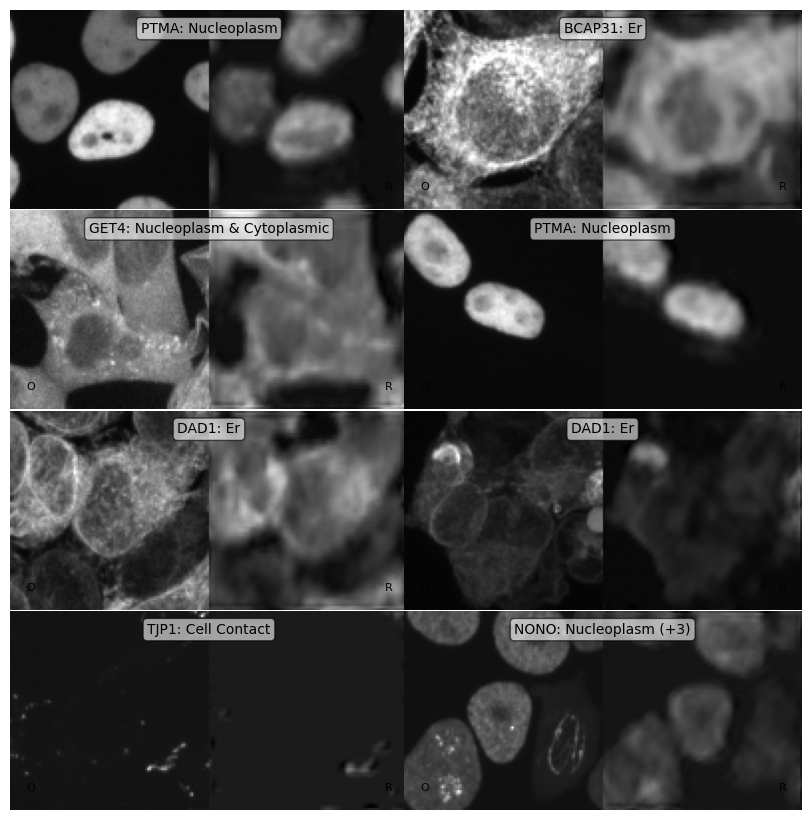

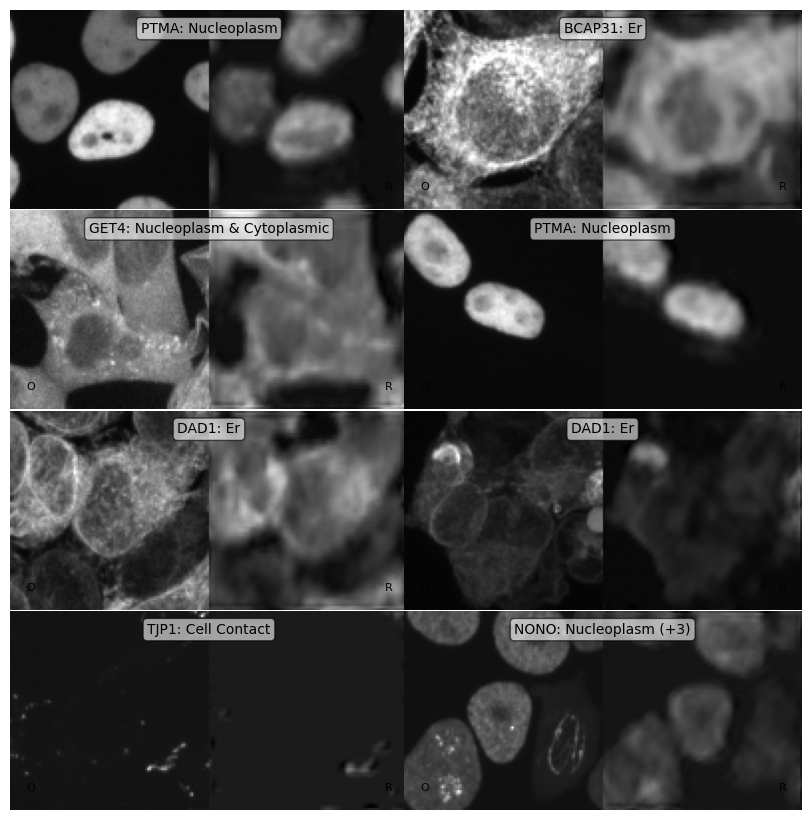

In [28]:
from dlfb.localization.inspect.reconstruction import show_reconstruction

show_reconstruction(dataset_splits["valid"], state, n=8, rng=rng_frames)

### 6.5.2. Evaluation Metrics over Epochs


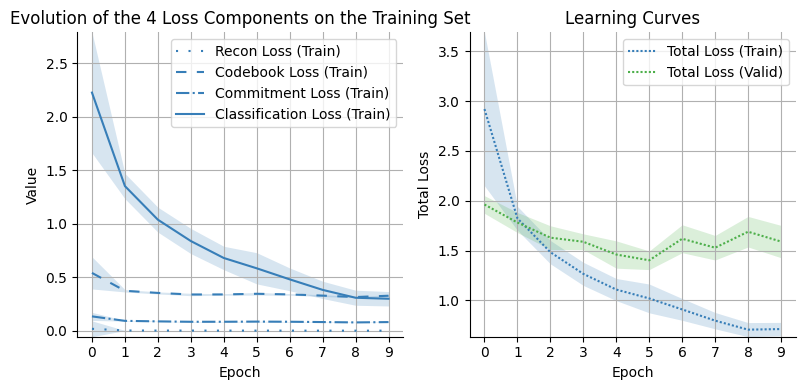

In [29]:
from dlfb.localization.inspect.metrics import plot_losses

plot_losses(metrics);

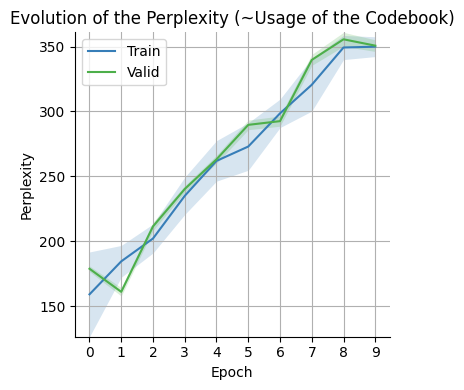

In [30]:
from dlfb.localization.inspect.metrics import plot_perplexity

plot_perplexity(metrics);

### 6.5.3. Model without Classification Task


In [31]:
state_alt, metrics_alt = train(
  state=model.create_train_state(
    rng=rng_init,
    dummy_input=dataset_splits["train"].get_dummy_input(),
    tx=optax.adam(0.001),
  ),
  rng=rng_train,
  dataset_splits=dataset_splits,
  num_epochs=10,
  batch_size=256,
  classification_weight=0,  # i.e. the protein id are ignored
  eval_every=1,
  store_path=assets("localization/models/small_alt"),
)

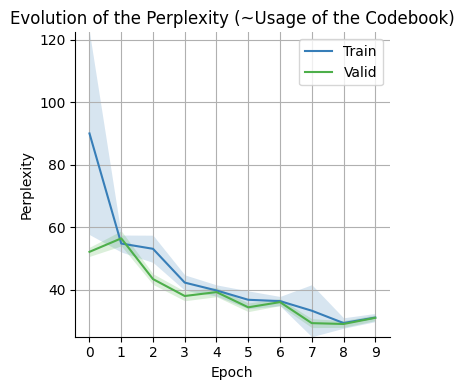

In [32]:
plot_perplexity(metrics_alt);

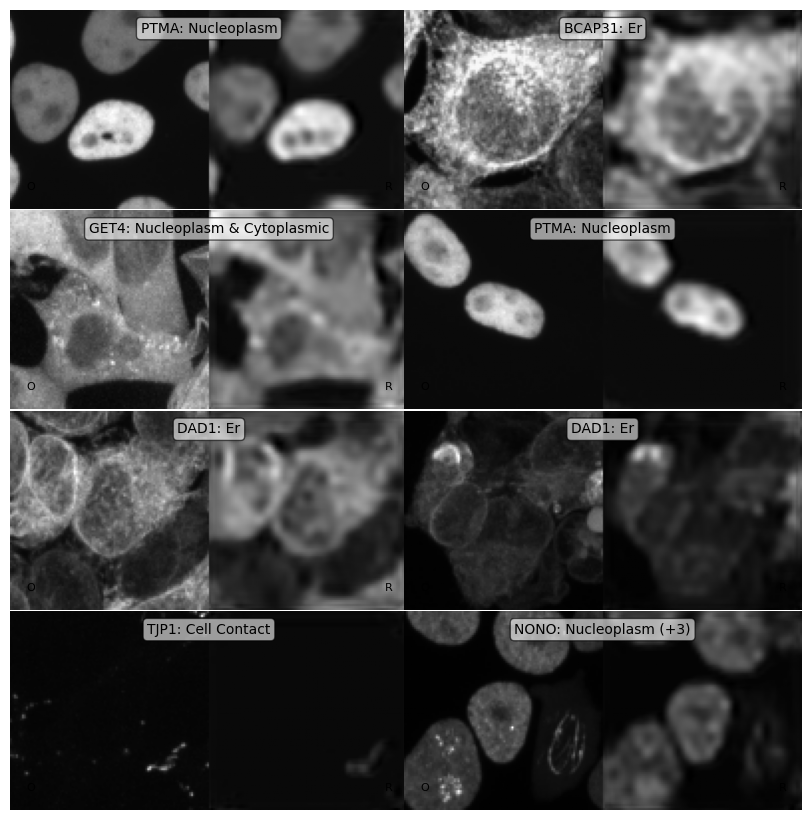

In [33]:
show_reconstruction(dataset_splits["valid"], state_alt, n=8, rng=rng_frames)

Without the auxiliary classification task (i.e., without the ClassificationHead), the model can focus more of its efforts on minimizing the reconstruction loss. This encourages it to memorize the input data as precisely as possible, often by collapsing to a small number of frequently used codebook entries. That’s why the reconstructions look sharper: the model has overfit to pixel-level detail rather than learning generalizable representations.

This same observation was highlighted in the original cytoself paper: adding classification-like objectives improves the quality of the latent space by pushing the model to encode meaningful, discriminative features. In fact, cytoself showed that models trained only to reconstruct images were far less effective at clustering localizations or identifying complexes, even when their reconstructions looked visually fine.

## 6.6. Understanding the Model
### 6.6.1. Understanding Localization Clustering


In [35]:
from dlfb.localization.inspect.embeddings.utils import get_frame_embeddings

display([get_frame_embeddings])
# extracts latent embeddings from the encoder for all frames in the dataset
# batch by batch for memory efficiency

# input (batch_size, 100, 100, 1) image
# encoder output (batch_size, 25, 25, latent_dim) feature map
# codebook output (batch_size, latent_dim) usage histogram

def get_frame_embeddings(
  state: TrainState,
  dataset_split: Dataset,
  batch_size: int = 256,
) -> dict[str, np.ndarray]:
  """Returns per-frame histograms of codebook encoding indices."""
  num_embeddings = get_num_embeddings(state)
  frame_ids, frame_histograms = [], []

  rng = jax.random.PRNGKey(42)
  for batch in dataset_split.get_batches(rng, batch_size):
    frame_ids.append(batch["frame_ids"])
    encoding_indices = pluck_encodings(state, batch)

    # Reshape and count codebook usage per frame.
    frame_histograms.append(
      np.apply_along_axis(
        lambda x: np.histogram(x, bins=np.arange(0, num_embeddings + 0.5))[0],
        axis=1,
        arr=jnp.reshape(encoding_indices, (batch_size, -1)),
      )
    )

  return {
    "frame_ids": np.concatenate(frame_ids),
    "frame_histograms": np.concatenate(frame_histograms, axis=0),
  }

In [35]:
# # Install a compatible NumPy version to resolve conflicts.
!pip install numpy==1.26.4 --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 35.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.2
    Uninstalling numpy-2.1.2:
      Successfully uninstalled numpy-2.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
datasets 4.0.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.9.0 which is incompatible.
datasets 4.0.0 requires requests>=2.32.2, but you have requests 2.28.1 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you ha

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


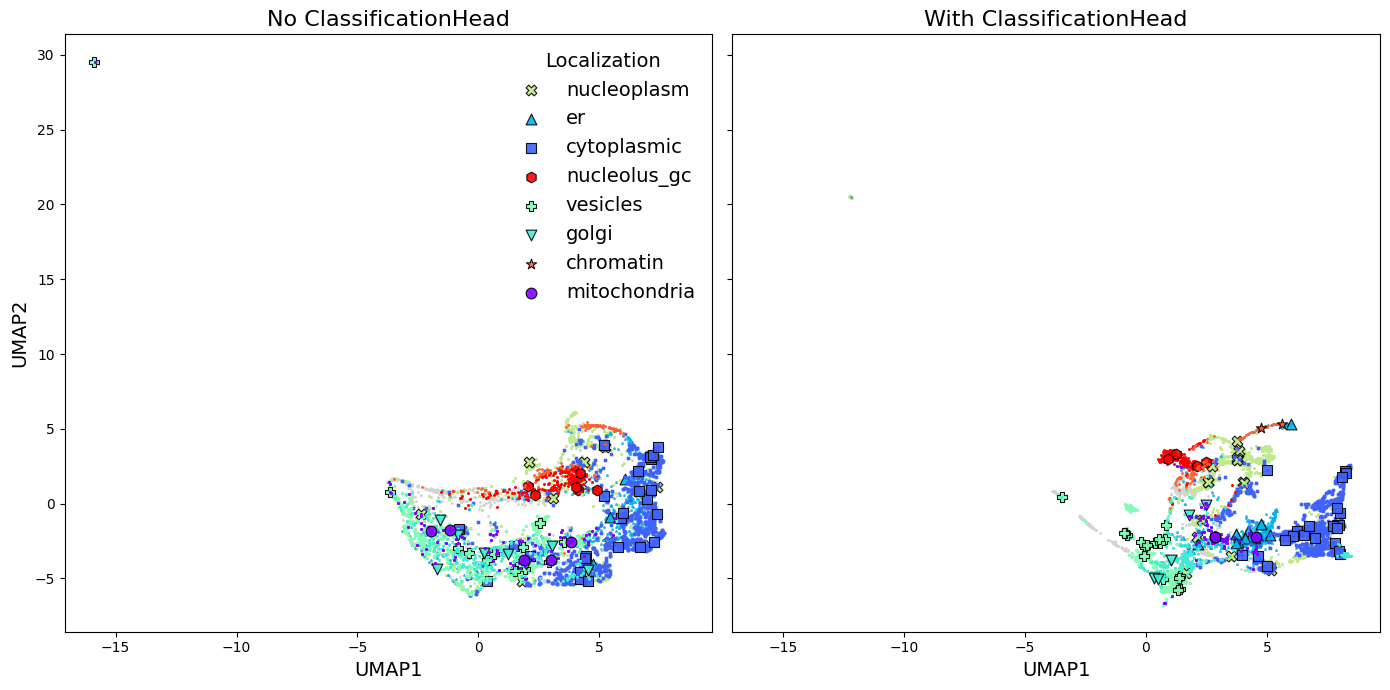

In [ ]:
from dlfb.localization.inspect.embeddings.clustering import (
  calculate_projection,
  plot_projection,
)
from dlfb.localization.inspect.embeddings.utils import get_frame_embeddings

frame_embeddings = {}
for name, s in zip(["no_head", "with_head"], [state_alt, state]):
  frame_embeddings[name] = get_frame_embeddings(s, dataset_splits["valid"])

projection = calculate_projection(frame_embeddings)
plot_projection(
  projection,
  dataset_splits["valid"],
  titles=["No ClassificationHead", "With ClassificationHead"],
)
# here "aligned" umap was applied to track shared data points accross embeddings of both models to ensure comparable projections
# 1% of frames from valid set are highlighted with larger markers for each predominant localization

UMAP looks different from what is reproduced in the textbook, but the quanlitative trend (how same frames fall into closer clusters) is still true.

### 6.6.2. Inspecting Feature Spectrums 

- See how codebook vectors correlate
- See how different cellular compartment feature different firing patterns

Define "protein feature spectrum" as the aggregated histogram of codebook usage of a single protein. The assumption behind this is that by encouraging high perplexity and performing auxiliary learning, we assume each quantized vector in codebook represent distinct aspects (both categorical and spatial) of proteins.


The firing pattern of codebook can be studied by computing the correlation of full protein histogram.

In [ ]:
from dlfb.localization.inspect.embeddings.utils import cluster_feature_spectrums

display([cluster_feature_spectrums])
# corr_idx_idx: correlation matrix between codebook vectors (Num_embeddings, Num_embeddings)

def cluster_feature_spectrums(
  protein_histograms: np.ndarray, n_clusters: int
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
  """Cluster proteins based on similarity in codebook usage patterns."""
  corr_idx_idx = np_pearson_cor(protein_histograms, protein_histograms)
  tree = linkage(
    corr_idx_idx,
    method="average",
    metric="euclidean",
    optimal_ordering=True,
  )
  encoding_clusters = fcluster(tree, n_clusters, criterion="maxclust")
  return corr_idx_idx, tree, encoding_clusters

In [38]:
from dlfb.localization.inspect.embeddings.feature_spectrum import (
  plot_encoding_corr_heatmap,
)
from dlfb.localization.inspect.embeddings.utils import aggregate_proteins

protein_ids, protein_histograms = aggregate_proteins(
  dataset_splits["valid"], **frame_embeddings["with_head"]
)
corr_idx_idx, tree, encoding_clusters = cluster_feature_spectrums(
  protein_histograms, n_clusters=8
)
plot_encoding_corr_heatmap(corr_idx_idx, tree, encoding_clusters);

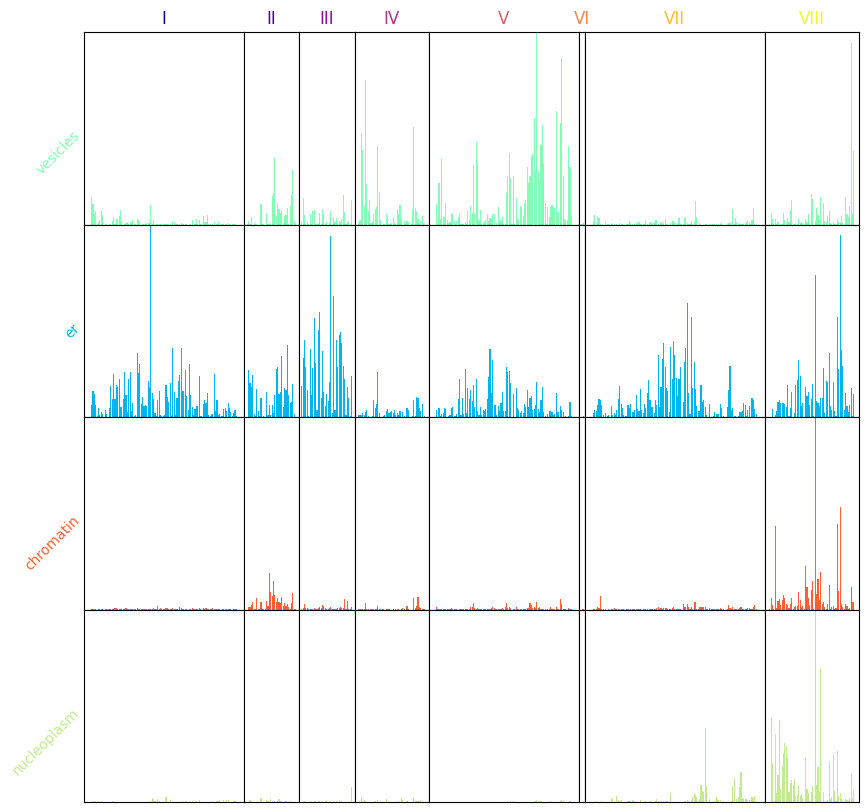

In [43]:
from dlfb.localization.inspect.embeddings.feature_spectrum import (
  plot_stacked_histrograms,
)
from dlfb.localization.inspect.embeddings.utils import aggregate_localizations

localizations, localization_histograms = aggregate_localizations(
  dataset_splits["valid"], protein_ids, protein_histograms
)
plot_stacked_histrograms(
  localizations, localization_histograms, tree, encoding_clusters
);

## 6.7. Improving the Model (Do not run it in Colab free version)
### 6.7.1. Scaling Up the Data


In [3]:
dataset_splits = DatasetBuilder(
  data_path=assets("localization/datasets")
).build(
  rng=rng_dataset,
  splits={"train": 0.80, "valid": 0.10, "test": 0.10},
  n_proteins=500,  # a larger number of proteins
)

model = LocalizationModel(
  num_classes=count_unique_proteins(dataset_splits),
  embedding_dim=64,
  num_embeddings=512,
  commitment_cost=0.25,
  dropout_rate=0.45,
  classification_head_layers=2,
)

state, metrics = train(
  state=model.create_train_state(
    rng=rng_init,
    dummy_input=dataset_splits["train"].get_dummy_input(),
    tx=optax.adam(0.001),
  ),
  rng=rng_train,
  dataset_splits=dataset_splits,
  num_epochs=10,
  batch_size=256,
  classification_weight=1,
  eval_every=1,
  store_path=assets("localization/models/large"),
)

In [4]:
from dlfb.localization.inspect.embeddings.feature_spectrum import (
  plot_stacked_histrograms,
)
from dlfb.localization.inspect.embeddings.utils import (
  aggregate_localizations,
  aggregate_proteins,
  cluster_feature_spectrums,
  get_frame_embeddings,
)

frame_embeddings = get_frame_embeddings(state, dataset_splits["valid"])
protein_ids, protein_histograms = aggregate_proteins(
  dataset_splits["valid"], **frame_embeddings
)
_, tree, encoding_clusters = cluster_feature_spectrums(
  protein_histograms, n_clusters=12
)
localizations, localization_histograms = aggregate_localizations(
  dataset_splits["valid"], protein_ids, protein_histograms
)
plot_stacked_histrograms(
  localizations, localization_histograms, tree, encoding_clusters
);

In [5]:
from dlfb.localization.inspect.embeddings.clustering import (
  calculate_projection,
  plot_projection,
)

projection = calculate_projection(frame_embeddings)
plot_projection(
  projection,
  dataset_splits["valid"],
  subset_mode="single",  # Only show frames with single localization
  titles=["Localization UMAP Projection"],
);

/usr/local/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


### 6.7.2. Going Further


## 6.8. Summary
